In [52]:
import pandas as pd
df = pd.read_csv('Data/youtube.csv')
df

,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,Natan por Aï¿,12300000,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,RobTopGames,12300000,3.741235e+08,Gaming,RobTopGames,39,Sweden,SE,Games,...,100000.0,2012.0,May,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


In [134]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from sklearn.base import BaseEstimator, ClusterMixin

class ThresholdBinning(BaseEstimator, ClusterMixin):
    """
    A custom clustering algorithm based on threshold binning.

    Parameters
    ----------
    max_bins : int, default=5
        The maximum number of bins to create.
        
    threshold : float, default=0.1
        The distance threshold for assigning data points to bins.
        
    min_bin_size : int, default=5
        Minimum number of samples required in a bin.
        
    verbose : bool, default=False
        Verbosity flag.
        
    Attributes
    ----------
    bins : dict
        Dictionary containing bins and their data points.
        
    centroids : dict
        Dictionary containing centroids of each bin.
    """

    def __init__(self, max_bins=5, threshold=0.1, min_bin_size=None, verbose=False):
        self.max_bins = max_bins
        self.threshold = threshold
        self.min_bin_size = min_bin_size
        self.verbose = verbose

    def fit(self, X, y=None):
        """
        Fit the model.
        
        Parameters
        ----------
        X : array-like or DataFrame of shape (n_samples, n_features)
            The input data.
        y : Ignored
            Not used, present for API consistency by convention.
        
        Returns
        -------
        self : object
            Fitted estimator.
        """
        self._threshold_binning(X)
        return self

    def fit_predict(self, X, y=None):
        """
        Fit the model and predict cluster indices.
        
        Parameters
        ----------
        X : array-like or DataFrame of shape (n_samples, n_features)
            The input data.
        y : Ignored
            Not used, present for API consistency by convention.
            
        Returns
        -------
        labels : array [n_samples]
            Index of the cluster each sample belongs to.
        """
        self.fit(X)
        return self._assign_labels(X)

    def _normalize_rows(self, df):
        return df.apply(lambda row: row / row.sum(), axis=1)

    def _calculate_centroid(self, bin_data):
        if not bin_data:
            return None
        return np.mean(bin_data, axis=0).tolist()

    def _threshold_binning(self, X):
        X = self._normalize_rows(X)
        self.bins = {0: [X.iloc[0].tolist()]}
        self.centroids = {0: self._calculate_centroid(self.bins[0])}

        for i in range(1, len(X)):
            self._assign_to_bin_or_create_new(X.iloc[i].tolist())

    def _assign_to_bin_or_create_new(self, row):
        assigned_bin, min_distance = self._find_closest_bin(row)
        if assigned_bin is not None:
            self.bins[assigned_bin].append(row)
            self.centroids[assigned_bin] = self._calculate_centroid(self.bins[assigned_bin])
        elif len(self.bins) < self.max_bins:
            new_bin_key = max(self.bins.keys()) + 1
            self.bins[new_bin_key] = [row]
            self.centroids[new_bin_key] = self._calculate_centroid(self.bins[new_bin_key])
            if self.verbose:
                print(f"Created a new bin: {new_bin_key}")

    def _find_closest_bin(self, row):
        min_distance = float('inf')
        assigned_bin = None
        for bin_key, centroid in self.centroids.items():
            distance = jensenshannon(row, centroid)
            if np.isfinite(distance) and distance < self.threshold and distance < min_distance:
                assigned_bin = bin_key
                min_distance = distance
        return assigned_bin, min_distance

    def _assign_labels(self, X):
        labels = np.full(len(X), -1)
        for i in range(len(X)):
            assigned_bin, _ = self._find_closest_bin(X.iloc[i].tolist())
            if assigned_bin is not None:
                labels[i] = assigned_bin

        self._handle_small_bins_and_remap(labels)
        self._remap_labels(labels)  # New method for remapping
        return labels

    def _remap_labels(self, labels):
        unique_labels = np.unique(labels)
        mapping = {label: i for i, label in enumerate(sorted(unique_labels))}
        
        # Special case for outlier bin
        if -1 in mapping:
            mapping[-1] = -1  # Make sure outlier bin remains as -1
        
        # Apply remapping
        for i in range(len(labels)):
            labels[i] = mapping[labels[i]]

        # Update bins and centroids accordingly
        new_bins = {}
        new_centroids = {}
        for old, new in mapping.items():
            if old in self.bins:
                new_bins[new] = self.bins[old]
                # Check if the key exists in self.centroids
                if old in self.centroids:
                    new_centroids[new] = self.centroids[old]
        
        self.bins = new_bins
        self.centroids = new_centroids



    def _handle_small_bins_and_remap(self, labels):
        # Move small bins to the outlier bin and remove them
        for bin_key in list(self.bins.keys()):
            if self.min_bin_size is not None and len(self.bins[bin_key]) < self.min_bin_size:
                if -1 not in self.bins:
                    self.bins[-1] = []
                self.bins[-1].extend(self.bins.pop(bin_key))
                del self.centroids[bin_key]
                if self.verbose:
                    print(f"Removed bin {bin_key} due to insufficient size.")

        # Adjust labels for moved data
        labels[np.isin(labels, list(self.bins.keys()), invert=True)] = -1

        # Remap bin keys to be sequential (excluding outlier bin)
        keys_to_remap = sorted([key for key in self.bins.keys() if key != -1])
        for i, old_key in enumerate(keys_to_remap):
            if old_key != i:
                self.bins[i] = self.bins.pop(old_key)
                self.centroids[i] = self.centroids.pop(old_key)
                labels[labels == old_key] = i
                
                



In [54]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import optuna

# df = pd.read_csv("your_data.csv")

# Drop rows with NaN values
df.dropna(inplace=True)


labels = df["category"]

# One-hot encode the categorical columns
# X = pd.get_dummies(df.drop("category", axis=1), drop_first=True)
X = pd.get_dummies(df)



In [58]:
df.dtypes

rank                                         int64
Youtuber                                    object
subscribers                                  int64
video views                                float64
category                                    object
Title                                       object
uploads                                      int64
Country                                     object
Abbreviation                                object
channel_type                                object
video_views_rank                           float64
country_rank                               float64
channel_type_rank                          float64
video_views_for_the_last_30_days           float64
lowest_monthly_earnings                    float64
highest_monthly_earnings                   float64
lowest_yearly_earnings                     float64
highest_yearly_earnings                    float64
subscribers_for_last_30_days               float64
created_year                   

In [57]:

# def objective(trial):
#     perplexity = trial.suggest_float('perplexity', 5, 50)
#     learning_rate = trial.suggest_float('learning_rate', 10, 1000)
#     scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'minmax', 'robust', 'none'])

#     if scaler_type == 'standard':
#         scaler = StandardScaler()
#     elif scaler_type == 'minmax':
#         scaler = MinMaxScaler()
#     elif scaler_type == 'robust':
#         scaler = RobustScaler()
#     else:
#         scaler = None

#     if scaler:
#         X_scaled = scaler.fit_transform(X)
#     else:
#         X_scaled = X.copy()

#     tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate)
#     X_tsne = tsne.fit_transform(X_scaled)

#     score = silhouette_score(X_tsne, labels)
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize


# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Results
# best_params = study.best_params
# best_score = study.best_value

# print(f"Best Silhouette Score: {best_score}")
# print(f"Best parameters: {best_params}")


In [56]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Best hyperparameters from Optuna
# best_perplexity = best_params['perplexity']
# best_learning_rate = best_params['learning_rate']
# best_scaler_type = best_params['scaler_type']

# # Scale the data based on the best scaler type
# if best_scaler_type == 'standard':
#     scaler = StandardScaler()
# elif best_scaler_type == 'minmax':
#     scaler = MinMaxScaler()
# elif best_scaler_type == 'robust':
#     scaler = RobustScaler()
# else:
#     scaler = None

# if scaler:
#     X_scaled = scaler.fit_transform(X)
# else:
#     X_scaled = X.copy()

# # Perform t-SNE with the best hyperparameters
# tsne = TSNE(n_components=2, perplexity=best_perplexity, learning_rate=best_learning_rate)
# X_tsne = tsne.fit_transform(X_scaled)

# # Create a DataFrame to hold the t-SNE coordinates and labels
# df_tsne = pd.DataFrame(data={'X': X_tsne[:, 0], 'Y': X_tsne[:, 1], 'category': labels})

# # Plot
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='X', y='Y', hue='category', data=df_tsne, palette='viridis')
# plt.title('t-SNE Visualization with Optimized Hyperparameters')
# plt.show()


In [59]:
df.dtypes

rank                                         int64
Youtuber                                    object
subscribers                                  int64
video views                                float64
category                                    object
Title                                       object
uploads                                      int64
Country                                     object
Abbreviation                                object
channel_type                                object
video_views_rank                           float64
country_rank                               float64
channel_type_rank                          float64
video_views_for_the_last_30_days           float64
lowest_monthly_earnings                    float64
highest_monthly_earnings                   float64
lowest_yearly_earnings                     float64
highest_yearly_earnings                    float64
subscribers_for_last_30_days               float64
created_year                   

In [61]:

#Use OHE for catgorical columns
X = pd.get_dummies(df)

#Convert all columns to float
X = X.astype(float)

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Run the clustering algorithm
clustering = ThresholdBinning(max_bins=30, threshold=0.5, min_bin_size=10, verbose=True)
labels = clustering.fit_predict(X)



Created a new bin: 1
Created a new bin: 2
Created a new bin: 3
Created a new bin: 4
Created a new bin: 5
Created a new bin: 6
Created a new bin: 7
Created a new bin: 8
Created a new bin: 9
Created a new bin: 10
Created a new bin: 11
Created a new bin: 12
Created a new bin: 13
Created a new bin: 14
Created a new bin: 15
Created a new bin: 16
Created a new bin: 17
Created a new bin: 18
Created a new bin: 19
Created a new bin: 20
Created a new bin: 21
Created a new bin: 22
Created a new bin: 23
Created a new bin: 24
Created a new bin: 25
Created a new bin: 26
Created a new bin: 27
Created a new bin: 28
Created a new bin: 29
Removed bin 1 due to insufficient size.
Removed bin 2 due to insufficient size.
Removed bin 3 due to insufficient size.
Removed bin 4 due to insufficient size.
Removed bin 5 due to insufficient size.
Removed bin 6 due to insufficient size.
Removed bin 7 due to insufficient size.
Removed bin 8 due to insufficient size.
Removed bin 9 due to insufficient size.
Removed bin

In [145]:
labels

array([ 1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,
        1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
       -1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
       -1,  1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,
       -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1,
        1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,
       -1, -1, -1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1,
        1,  1, -1, -1, -1

In [146]:
#Number of unique labels in the labels array
len(np.unique(labels))

2

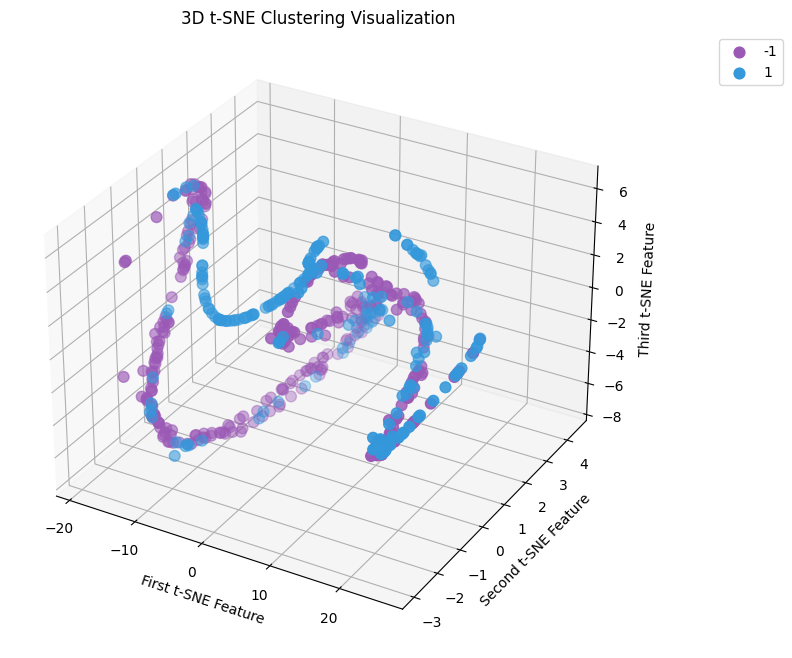

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import itertools

# Create a list of distinct colors for clusters.
custom_colors = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#FF7F50", "#800000", "#FFFF00", "#00FF00", "#FF00FF"]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign custom colors to unique labels
unique_labels = np.unique(labels)
color_cycle = itertools.cycle(custom_colors)  # Create an iterator to cycle through the color list
palette = {label: next(color_cycle) for label in unique_labels}  # Assign a color to each unique label

for label in unique_labels:
    mask = labels == label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2], c=palette[label], label=label, s=60)

ax.set_title('3D t-SNE Clustering Visualization')
ax.set_xlabel('First t-SNE Feature')
ax.set_ylabel('Second t-SNE Feature')
ax.set_zlabel('Third t-SNE Feature')

# Move legend far outside of the plot
ax.legend(bbox_to_anchor=(1.14,1), loc="upper left")

plt.show()
